In [1]:
import numpy as np # linear algebra
np.random.seed(1337) #reproducibility
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import os
import pandas as pd
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt
import gc
import IPython.display as ipd

In [3]:
train_path = r'C:\Users\Gundeep Gulati\Desktop\Language_Identification_dataset\archive\train\train\'
test_path = '../input/spoken-language-identification/test/test/'

In [4]:
filename = 'de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.flac'

In [5]:
data, samplerate = sf.read(train_path+filename)

In [6]:
import os
print(os.listdir('../input'))
import pandas as pd

['spoken-language-identification']


In [7]:
import gc
gc.collect()

100

In [8]:
data.shape

(220500,)

In [9]:
#el flac cargado
data[:10]

array([-0.03903198, -0.03997803, -0.05319214, -0.06002808, -0.0531311 ,
       -0.04608154, -0.04348755, -0.02947998, -0.02307129, -0.02459717])

In [10]:
samplerate

22050

In [11]:
ipd.Audio(train_path+filename)

Text(0.5, 0, 'Time [sec]')

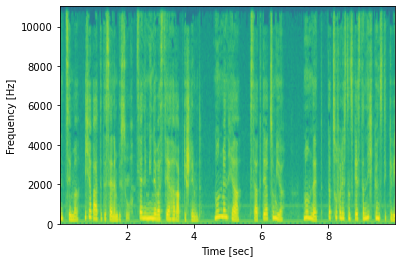

In [12]:
Pxx, freqs, bins, im = plt.specgram(data, Fs=samplerate)

# add axis labels
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

Text(0.5, 0, 'Time in samples')

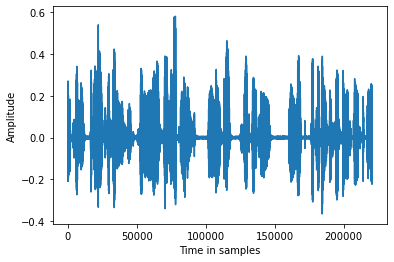

In [13]:
plt.plot(data)

# add axis labels
plt.ylabel('Amplitude')
plt.xlabel('Time in samples')

In [14]:
filename[:2]

'de'

In [15]:
#para train path
label = []
for filename in os.listdir(train_path):
    label.append(filename[:2])

In [16]:
label_t = []
for filename in os.listdir(test_path):
    label_t.append(filename[:2])

In [17]:
print(len(label))
print(len(label_t))

73080
540


In [18]:
file = []
for filename in os.listdir(train_path):
    file.append(filename)

In [19]:
file_t = []
for filename in os.listdir(test_path):
    file_t.append(filename)

In [20]:
Label = pd.DataFrame(label,columns=['Language'])


In [21]:
Label['Language'].value_counts()

de    24360
es    24360
en    24360
Name: Language, dtype: int64

In [22]:
data = {'filename':file,
       'languange':label}

In [23]:
data_t = {'filename':file_t,
       'languange':label_t}

In [24]:
#df es el dataframe de train
df = pd.DataFrame(data)

In [25]:
#df_t es el dataframe de test
df_t = pd.DataFrame(data_t)


In [26]:
df['filename'][0]

'es_m_b53274d3ef7996a22d6ec929c1869804.fragment12.speed1.flac'

In [27]:
def generate_fb_and_mfcc(signal, sample_rate):

    # Pre-Emphasis
    pre_emphasis = 0.97
    emphasized_signal = np.append(
        signal[0],
        signal[1:] - pre_emphasis * signal[:-1])

    # Framing
    frame_size = 0.025
    frame_stride = 0.01

    # Convert from seconds to samples
    frame_length, frame_step = (
        frame_size * sample_rate,
        frame_stride * sample_rate)
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))

    # Make sure that we have at least 1 frame
    num_frames = int(
        np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))

    # Pad Signal to make sure that all frames have equal
    # number of samples without truncating any samples
    # from the original signal
    pad_signal = np.append(emphasized_signal, z)

    indices = (
        np.tile(np.arange(0, frame_length), (num_frames, 1)) +
        np.tile(
            np.arange(0, num_frames * frame_step, frame_step),
            (frame_length, 1)
        ).T
    )
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # Window
    frames *= np.hamming(frame_length)

    # Fourier-Transform and Power Spectrum
    NFFT = 512

    # Magnitude of the FFT
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))

    # Power Spectrum
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Filter Banks
    nfilt = 40

    low_freq_mel = 0

    # Convert Hz to Mel
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))

    # Equally spaced in Mel scale
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)

    # Convert Mel to Hz
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)

    # Numerical Stability
    filter_banks = np.where(
        filter_banks == 0,
        np.finfo(float).eps,
        filter_banks)

    # dB
    filter_banks = 20 * np.log10(filter_banks)

    # MFCCs
    # num_ceps = 12
    # cep_lifter = 22

    # ### Keep 2-13
    # mfcc = dct(
    #     filter_banks,
    #     type=2,
    #     axis=1,
    #     norm='ortho'
    # )[:, 1 : (num_ceps + 1)]

    # (nframes, ncoeff) = mfcc.shape
    # n = np.arange(ncoeff)
    # lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    # mfcc *= lift
    #filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
    return filter_banks

In [28]:
from sklearn.model_selection import train_test_split


In [29]:
X_train,X_test,y_train,y_test = train_test_split(df,df['languange'],stratify = df['languange'],test_size = 0.5,random_state = 0)
print(X_train['languange'].value_counts())
print(X_test['languange'].value_counts())

es    12180
de    12180
en    12180
Name: languange, dtype: int64
es    12180
de    12180
en    12180
Name: languange, dtype: int64


In [30]:
X_train,X_test,y_train,y_test = train_test_split(X_train,X_train['languange'],stratify = X_train['languange'],test_size = 0.5,random_state = 0)
print(X_train['languange'].value_counts())
print(X_test['languange'].value_counts())

de    6090
es    6090
en    6090
Name: languange, dtype: int64
de    6090
es    6090
en    6090
Name: languange, dtype: int64


In [31]:
X_train,X_test,y_train,y_test = train_test_split(X_train,X_train['languange'],stratify = X_train['languange'],test_size = 0.5,random_state = 0)
print(X_train['languange'].value_counts())
print(X_test['languange'].value_counts())

de    3045
en    3045
es    3045
Name: languange, dtype: int64
de    3045
en    3045
es    3045
Name: languange, dtype: int64


In [32]:
X_train,X_test,y_train,y_test = train_test_split(X_train,X_train['languange'],stratify = X_train['languange'],test_size = 0.6,random_state = 0)
print(X_train['languange'].value_counts())
print(X_test['languange'].value_counts())

en    1218
de    1218
es    1218
Name: languange, dtype: int64
de    1827
en    1827
es    1827
Name: languange, dtype: int64


In [33]:
X_train['filename'].values[:2]

array(['en_f_fff98d05640df27726dcd6183642ffaa.fragment24.speed5.flac',
       'en_m_f7d28f7498eaf373b312abcdc0886951.fragment15.speed6.flac'],
      dtype=object)

In [34]:
X_train.head()

,filename,languange
49335,en_f_fff98d05640df27726dcd6183642ffaa.fragment...,en
71901,en_m_f7d28f7498eaf373b312abcdc0886951.fragment...,en
47355,en_f_386ee651f6f1539ff5622c55e234e5a4.fragment...,en
12633,en_m_011f3a2d0aa2880305c08b76873c3e10.fragment...,en
58639,es_f_47bd2e6178465cd745c86c9db5ffe447.fragment...,es


In [35]:
#reseteamos los indices
X_train = X_train.reset_index(drop = True)
X_train.head()

,filename,languange
0,en_f_fff98d05640df27726dcd6183642ffaa.fragment...,en
1,en_m_f7d28f7498eaf373b312abcdc0886951.fragment...,en
2,en_f_386ee651f6f1539ff5622c55e234e5a4.fragment...,en
3,en_m_011f3a2d0aa2880305c08b76873c3e10.fragment...,en
4,es_f_47bd2e6178465cd745c86c9db5ffe447.fragment...,es


In [36]:
gc.collect()

20

In [37]:
series = []
length = []
for filename in X_train['filename'].values:
    flac, samplerate = sf.read(train_path+filename)
    series.append(flac)
    length.append(samplerate)

In [38]:
X_train['Series'] = series
X_train['Length'] = length
X_train.head(20)

,filename,languange,Series,Length
0,en_f_fff98d05640df27726dcd6183642ffaa.fragment...,en,"[0.0028076171875, 0.003875732421875, 0.0036315...",22050
1,en_m_f7d28f7498eaf373b312abcdc0886951.fragment...,en,"[0.010040283203125, 0.013763427734375, 0.00262...",22050
2,en_f_386ee651f6f1539ff5622c55e234e5a4.fragment...,en,"[-0.00933837890625, -0.00225830078125, 0.02273...",22050
3,en_m_011f3a2d0aa2880305c08b76873c3e10.fragment...,en,"[0.07745361328125, 0.10418701171875, 0.0921325...",22050
4,es_f_47bd2e6178465cd745c86c9db5ffe447.fragment...,es,"[0.043182373046875, 0.029876708984375, 0.01992...",22050
5,en_f_c8835fb3edef243176e1e9beef1f9681.fragment...,en,"[0.014404296875, 0.010498046875, -0.0144653320...",22050
6,es_m_d5b91a4ffb1ead826b7968ec19cbfa1c.fragment...,es,"[6.103515625e-05, 0.000244140625, 0.0001525878...",22050
7,es_m_d5b91a4ffb1ead826b7968ec19cbfa1c.fragment...,es,"[0.0157470703125, 0.01593017578125, 0.01367187...",22050
8,es_m_406bb0dc71a22051d900bc55cdfad59e.fragment...,es,"[0.002777099609375, 0.00482177734375, 0.006683...",22050
9,en_f_10134f409d9b7b0b95fed6e025febcad.fragment...,en,"[-0.00299072265625, -0.004241943359375, -0.002...",22050


In [39]:
len(X_train)

3654

In [40]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [41]:
##### Clearing the memory and reusing the notebook
gc.collect()

100

In [42]:
#genero filter banks y mfccs para train
MFCC_array = []
for i in range(0,len(X_train)):
    MFCC = generate_fb_and_mfcc(X_train['Series'][i], X_train['Length'][i])
    MFCC_sc = sc.fit_transform(MFCC)
    MFCC_array.append(MFCC_sc)
MFCC_array = np.array(MFCC_array)

In [43]:
np.save('../working/MFCC_data',MFCC_array)

In [44]:
#repito todo para test
series_t = []
length_t = []
for filename in df_t['filename'].values:
    flac, samplerate = sf.read(test_path+filename)
    series_t.append(flac)
    length_t.append(samplerate)

In [45]:
df_t['Series'] = series_t
df_t['Length'] = length_t
df_t.head()

,filename,languange,Series,Length
0,es_f_50298ab71aaba8508ebeef49d853df11.fragment...,es,"[0.079864501953125, 0.079193115234375, 0.08142...",22050
1,es_m_08111ce8d6a7ebc6cd2c27e62a3d98f0.fragment...,es,"[3.0517578125e-05, 6.103515625e-05, 3.05175781...",22050
2,en_f_67a0cba10d171b24039a79faa1d4d603.fragment...,en,"[0.000274658203125, 0.0003662109375, 0.0004272...",22050
3,de_m_923551d571cc437382d0294dda2dd0aa.fragment...,de,"[-0.1868896484375, -0.177001953125, -0.1701660...",22050
4,es_f_50298ab71aaba8508ebeef49d853df11.fragment...,es,"[0.127655029296875, 0.127105712890625, 0.12649...",22050


In [46]:
##genero filter banks y mfccs para test, el que tiene 540 items
MFCC_array_t = []
for i in range(0,len(df_t)):
    MFCC = generate_fb_and_mfcc(df_t['Series'][i], df_t['Length'][i])
    MFCC_sc = sc.fit_transform(MFCC)
    MFCC_array_t.append(MFCC_sc)
MFCC_array_t = np.array(MFCC_array_t) 

In [47]:
np.save('../working/MFCC_data_t',MFCC_array_t)

In [48]:
#language dummies tiene los one hot encoding para X_train
#language dummies_t tiene los one hot encoding para df_t; i.e. [0, 1, 0], etc
language_dummies = pd.get_dummies(X_train['languange'])
language_dummies_t = pd.get_dummies(df_t['languange'])
np.save('../working/language_dummy',language_dummies.values)
np.save('../working/language_dummy_t',language_dummies_t.values)

In [49]:
import librosa
import librosa.display

In [50]:
MFCC_array = np.load('../working/MFCC_data.npy')

In [51]:
language_dummies = np.load('../working/language_dummy.npy')
language_dummies_t = np.load('../working/language_dummy_t.npy')

In [52]:
language_dummies_t[:5]

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]], dtype=uint8)

In [53]:
X_train_MFCC,X_test_MFCC,y_train_MFCC,y_test_MFCC = train_test_split(MFCC_array,language_dummies,stratify = language_dummies,test_size = 0.10,random_state = 0)

In [54]:
X_train_MFCC.shape

(3288, 1000, 40)

In [55]:
X_train_MFCC = X_train_MFCC.reshape(-1,1000,40,1)

In [56]:
X_test_MFCC = X_test_MFCC.reshape(-1,1000,40,1)

In [57]:
y_train_MFCC 
y_test_MFCC
len(X_train_MFCC)

3288

In [58]:
from sklearn import preprocessing
from sklearn.metrics import classification_report,confusion_matrix

from keras.models import Model, load_model, Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten
from keras.layers import Dropout, Input, Activation
from keras.optimizers import Nadam, SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras import regularizers

In [59]:
input_shape = (1000,40,1)
model = Sequential()
# model.add(Conv2D(32,(3, 3),strides=(1, 1),padding='same',kernel_regularizer=regularizers.l2(0.0007),
#         input_shape=input_shape,data_format = 'channels_last'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
# model.add(Conv2D(64,(3, 3),strides=(1, 1),padding='same',kernel_regularizer=regularizers.l2(0.0007)))
#         #kernel_regularizer=regularizers.l2(0.001)))
# model.add(Activation('relu'))
# #model.add(Dropout(0.4))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
# model.add(AveragePooling2D(pool_size=(3, 3),strides=(2, 2),padding='same'))
# model.add(Flatten())
# model.add(Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.0007)))       # kernel_regularizer=regularizers.l2(0.001)))
# model.add(Dropout(0.40))
# model.add(BatchNormalization())
# model.add(Dense(3))
# model.add(Activation('softmax'))

#---------------------------- NEW MODEL

model.add(Conv2D(32,(7, 7), activation='relu', padding='valid', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(64,(5,5), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(512,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


#sgd = SGD(lr=0.01, decay=1, momentum=0.0, nesterov=False)
#sgd = sgd(lr=0.01, decay=1e-6, momentum=0.0, nesterov=False)
#adam = Adam(lr=0.01, decay=1e-6)
import math
from keras.callbacks import LearningRateScheduler
adam = Adam()
def step_decay(epoch):
    # 00158 = 90.4%
	initial_lrate = 0.00158
	drop = 0.9
	epochs_drop = 1
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate


model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])



checkpoint = ModelCheckpoint(
                'model.h5',
                monitor='val_acc',
                verbose=0,
                save_best_only=True,
                mode='max'
                )

lrate = LearningRateScheduler(step_decay)
#es = EarlyStopping(monitor='val_loss',mode = 'max')
model.fit(
                X_train_MFCC,
                y_train_MFCC,
                epochs=60,
                callbacks=[checkpoint, lrate],
                verbose=1,
                validation_data=(X_test_MFCC, y_test_MFCC),
                batch_size=32)

Epoch 1/60
103/103 [==============================] - 5s 49ms/step - loss: 1.4332 - accuracy: 0.4319 - val_loss: 3.1699 - val_accuracy: 0.3443
Epoch 2/60
103/103 [==============================] - 4s 42ms/step - loss: 0.8363 - accuracy: 0.6700 - val_loss: 2.0932 - val_accuracy: 0.5492
Epoch 3/60
103/103 [==============================] - 4s 41ms/step - loss: 0.4915 - accuracy: 0.8203 - val_loss: 0.9791 - val_accuracy: 0.6776
Epoch 4/60
103/103 [==============================] - 4s 42ms/step - loss: 0.2849 - accuracy: 0.8932 - val_loss: 0.9257 - val_accuracy: 0.6475
Epoch 5/60
103/103 [==============================] - 4s 41ms/step - loss: 0.1723 - accuracy: 0.9425 - val_loss: 1.0610 - val_accuracy: 0.6694
Epoch 6/60
103/103 [==============================] - 4s 42ms/step - loss: 0.1122 - accuracy: 0.9574 - val_loss: 0.7549 - val_accuracy: 0.7486
Epoch 7/60
103/103 [==============================] - 4s 43ms/step - loss: 0.0742 - accuracy: 0.9751 - val_loss: 0.4233 - val_accuracy: 0.8743

Epoch 58/60
103/103 [==============================] - 4s 41ms/step - loss: 6.1343e-04 - accuracy: 1.0000 - val_loss: 0.0826 - val_accuracy: 0.9809
Epoch 59/60
103/103 [==============================] - 4s 42ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0854 - val_accuracy: 0.9699
Epoch 60/60
103/103 [==============================] - 4s 41ms/step - loss: 8.1837e-04 - accuracy: 1.0000 - val_loss: 0.0845 - val_accuracy: 0.9699


In [60]:
model = load_model('model.h5')

OSError: SavedModel file does not exist at: model.h5/{saved_model.pbtxt|saved_model.pb}

In [61]:
model.evaluate(X_test_MFCC,y_test_MFCC)

12/12 [==============================] - 0s 16ms/step - loss: 0.0845 - accuracy: 0.9699


[0.08448226004838943, 0.9699453711509705]

In [62]:
y_pred = model.predict(X_test_MFCC)

In [63]:
y_test1 = []
for i in range(0,len(y_test_MFCC)):
    argmax = np.argmax(y_test_MFCC[i,:])
    y_test1.append(argmax)


In [64]:
y_pred1 = []
for i in range(0,len(y_test_MFCC)):
    argmax = np.argmax(y_pred[i,:])
    y_pred1.append(argmax)

In [65]:
confusion_matrix(y_test1,y_pred1)

array([[116,   5,   1],
       [  4, 117,   1],
       [  0,   0, 122]])

In [66]:
print(classification_report(y_test1,y_pred1))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       122
           1       0.96      0.96      0.96       122
           2       0.98      1.00      0.99       122

    accuracy                           0.97       366
   macro avg       0.97      0.97      0.97       366
weighted avg       0.97      0.97      0.97       366



In [67]:
MFCC_array_t = np.load('../working/MFCC_data_t.npy')

In [68]:
MFCC_array_t.shape

(540, 1000, 40)

In [69]:
MFCC_array_t = MFCC_array_t.reshape(-1,1000,40,1)

In [70]:
predictions = model.predict(MFCC_array_t)

In [71]:
predictions

array([[9.7832572e-06, 1.1204851e-07, 9.9999011e-01],
       [2.8447303e-04, 1.2554991e-04, 9.9958998e-01],
       [2.5362743e-04, 9.9973756e-01, 8.8181223e-06],
       ...,
       [1.8973822e-04, 9.8725593e-01, 1.2554309e-02],
       [5.2247733e-06, 9.9999022e-01, 4.5517295e-06],
       [1.5971978e-04, 5.5664746e-06, 9.9983466e-01]], dtype=float32)

In [72]:
y_pred1 = []
for i in range(0,len(predictions)):
    argmax = np.argmax(predictions[i,:])
    y_pred1.append(argmax)

In [73]:
y_test1 = []
for i in range(0,len(language_dummies_t)):
    argmax = np.argmax(language_dummies_t[i,:])
    y_test1.append(argmax)
    

In [74]:
#confusion_matrix(y_test1,y_pred1)
cm = confusion_matrix(y_test1,y_pred1)
print(np.around(cm/cm.sum(axis=1, keepdims=True)*100,1))

[[ 99.4   0.    0.6]
 [  0.   98.9   1.1]
 [  0.    0.  100. ]]


In [ ]:
print(classification_report(y_test1,y_pred1))